# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## Project 1:
## Simulation of House Prices in Ireland

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import httpx
from selectolax.parser import HTMLParser

In [2]:
# Set seed for reproducibility
np.random.seed(10)

# Number of samples
num_samples = 500

### **Introduction**
For this data analytics project, I have chosen to simulate a dataset related to house prices in Ireland.

**Variables**

1. House Price
1. House Size
1. Number of Bedrooms
1. Location

### **House Price:**

The dependent variable representing the market value of a house. This will be a continuous variable with a positive real number format.

**Data Generation**

Simulate house prices using a normal distribution. Research on local housing markets can provide insights into the mean and standard deviation for generating realistic price data.

Maybe log normal distributed is better.

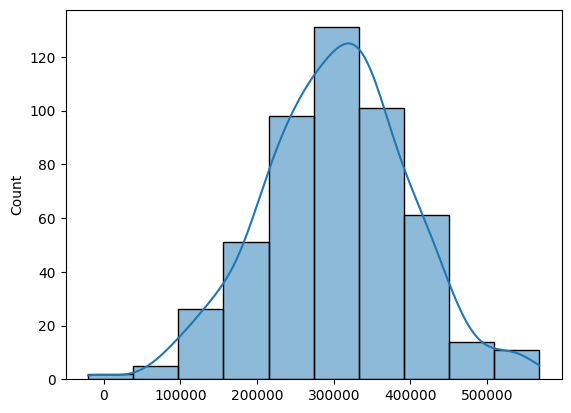

In [3]:
base_price = 0

mean_price = 300000
std_dev_price = 100000

house_prices = np.random.normal(mean_price, std_dev_price, num_samples)

sns.histplot(house_prices, kde=True, bins=10);

### **House Size:**

The size of the house in meters squared. This will be a positive real floating point number.

**Data Generation**


Simulate house size using a normal distribution.

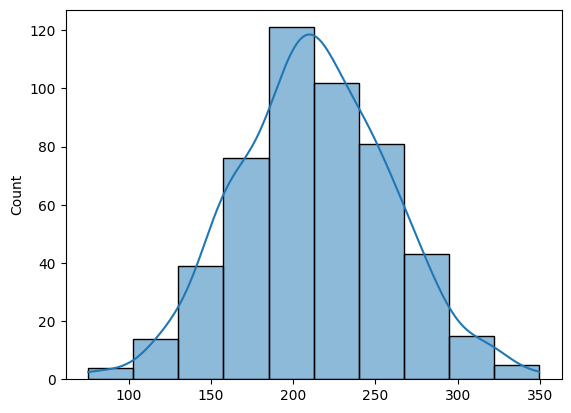

In [4]:
mean_house_size_m2 = 216
std_dev_house_size_m2 = 50

house_size = np.random.normal(mean_house_size_m2, std_dev_house_size_m2, num_samples)

sns.histplot(house_size, kde=True, bins=10);

#### **Number of Bedrooms:**

The count of bedrooms in a house. This will be a positive integer.

**Data Generation**

Simulate the number of bedrooms using a discrete distribution. Research on typical bedroom counts in houses can guide the distribution.

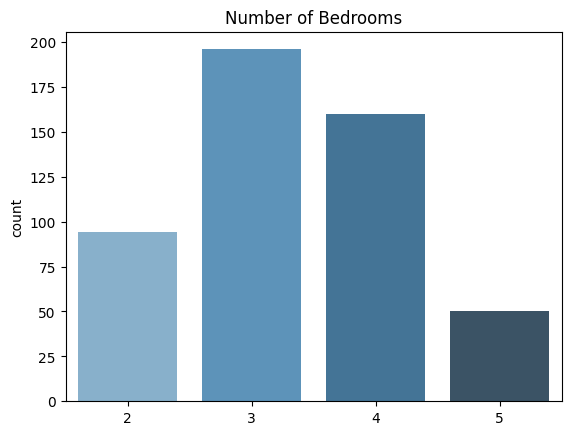

In [5]:
bedroom_count = np.random.choice([2, 3, 4, 5], size=num_samples, p=[0.2, 0.4, 0.3, 0.1])

sns.countplot(x=bedroom_count, palette='Blues_d')
plt.title('Number of Bedrooms');

### **Location**

Geographic variable representing the location of the house.

**Data Generation**

?

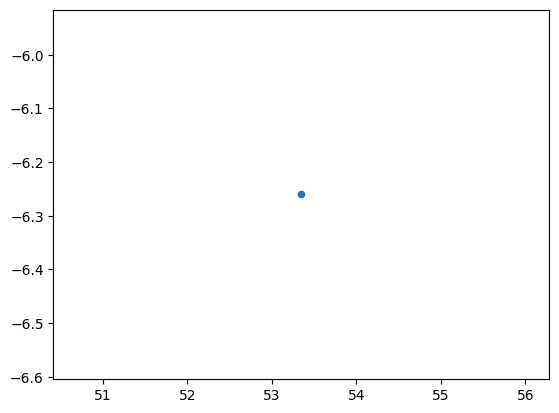

In [6]:
latitude = 53.3498
longitude = -6.2603

sns.scatterplot(x=[latitude],y=[longitude]);

In [7]:
# Create DataFrame
house_data = pd.DataFrame({
    'House_Price': house_prices.round(2),
    'House_Size': house_size.round(2),
    'Bedrooms': bedroom_count,
})

house_data.head()

,House_Price,House_Size,Bedrooms
0,433158.65,287.96,3
1,371527.90,285.11,4
2,145459.97,262.07,4
3,299161.62,187.36,3
4,362133.60,279.75,4


Real property data is hard to come by so I decided to scrape Daft. I needed to figure out the average size of a house and the minimum house price somehow.

In [8]:
import httpx
from selectolax.parser import HTMLParser
import time

def get_html(baseurl, page):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"}
    resp = httpx.get(baseurl + str((page*20)-20), headers=headers)
    resp.raise_for_status()
    try:
        resp.raise_for_status()
    except httpx.HTTPStatusError as exc:
        print(f"Error response {exc.response.status_code} while requesting {exc.request.url!r}. Page Limit Exceeded")
        return False # Returns False when it exceeds the last webpage in order to stop the loop.
    html = HTMLParser(resp.text)
    return html

def extract_text(html, sel):
    try:
        return html.css_first(sel).text(strip=True)
    except AttributeError:
        return None
        
def parse_page(html):
    card_elements = html.css("div[data-testid='card-body']")

    for card_element in card_elements:
        property_info = {
            "Address": extract_text(card_element, "[data-testid='address']"),
            "Price": extract_text(card_element, "[data-testid='price']"),
            "Bedrooms": extract_text(card_element, "[data-testid='beds']"),
            "Bathrooms": extract_text(card_element, "[data-testid='baths']"),
            "Floor Area": extract_text(card_element, "[data-testid='floor-area']"),
            "Property Type": extract_text(card_element, "[data-testid='property-type']")
        }
        yield property_info

def main():
    baseurl = "https://www.daft.ie/property-for-sale/ireland?pageSize=20&from="
    for x in range(1,100):
        print(f"Gathering page: {x}")
        html = get_html(baseurl, x)
        
        if html is False:
            break
        data = parse_page(html)
        for item in data:
            print(item)
        time.sleep(1)

In [9]:
main()

Gathering page: 1
{'Address': 'Mellenton House, Carlow Town, Co. Carlow, R93R796', 'Price': '€525,000', 'Bedrooms': '6 Bed', 'Bathrooms': '3 Bath', 'Floor Area': '230 m²', 'Property Type': 'Detached'}
{'Address': '16 The Gates, Matthew Hill, Lehenaghmore, Co. Cork, T12APH0', 'Price': '€675,000', 'Bedrooms': '5 Bed', 'Bathrooms': '3 Bath', 'Floor Area': '204 m²', 'Property Type': 'Detached'}
{'Address': 'Apartment 10, South Quay, The Maltings, Midleton, Co. Cork, P25Y978', 'Price': '€235,000', 'Bedrooms': '2 Bed', 'Bathrooms': '2 Bath', 'Floor Area': '82 m²', 'Property Type': 'Townhouse'}
{'Address': 'Apartment 2, Ryston View, Newbridge, Co. Kildare, W12KX23', 'Price': '€300,000', 'Bedrooms': '2 Bed', 'Bathrooms': '2 Bath', 'Floor Area': '75 m²', 'Property Type': 'Apartment'}
{'Address': '12 Croghtamore Gardens, Pouladuff Road, Pouladuff, Co. Cork, T12W0D7', 'Price': '€295,000', 'Bedrooms': '3 Bed', 'Bathrooms': '2 Bath', 'Floor Area': '85 m²', 'Property Type': 'Semi-D'}
{'Address': '67

ReadTimeout: The read operation timed out

### **Relationships**

**Correlation between House Price and House Size:**

Simulate a positive correlation between house price and house size, as larger houses generally tend to have higher prices.

**Influence of Number of Bedrooms:**

Simulate an influence of the number of bedrooms on house price. Larger houses with more bedrooms should have higher prices.

**Geographic Location Impact:**

Introduce a relationship between geographic location and house price. Certain geographic areas may positively or negatively influence house prices.


https://www.spcforexcel.com/knowledge/basic-statistics/deciding-which-distribution-fits-your-data-best/


https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/
https://statisticsbyjim.com/basics/goodness-of-fit/
https://statisticsbyjim.com/basics/skewed-distribution/

https://docs.scipy.org/doc/scipy/reference/stats.html

Note that this example covers continuous data. For categorical and discrete variables, you should use the chi-square goodness of fit test.

https://statisticsbyjim.com/hypothesis-testing/chi-square-goodness-of-fit-test/



https://archive.ph/20230811082152/https://towardsdatascience.com/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd#selection-643.182-653.170

https://www.datacamp.com/tutorial/probability-distributions-python

https://www.analyticsvidhya.com/blog/2021/09/q-q-plot-ensure-your-ml-model-is-based-on-the-right-distributions/https://archive.ph/20221125141253/https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f#selection-965.3-979.30

https://numpy.org/doc/1.16/reference/routines.random.html

https://stackoverflow.com/questions/45579525/returning-a-dataframe-in-python-function

https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/


https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart


https://stackoverflow.com/questions/69141790/seaborn-reg-plots-with-the-same-y-axis-scale-side-by-side


Right Skewed. The mean overestimates the most common values in a positively skewed distribution.

Using a QQ Plot to determine if the dristribution follows a probability distribution...?

https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_gumbel_l.html


https://www.statista.com/statistics/1417857/ireland-mean-new-home-size/

https://ec.europa.eu/eurostat/cache/digpub/housing/bloc-1b.html?lang=en

https://www.cso.ie/en/interactivezone/syntheticdata/housepricesyntheticdataset/

https://en.wikipedia.org/wiki/Parametric_statistics

https://www.youtube.com/@JohnWatsonRooney/videos

https://www.youtube.com/watch?v=1PCWwK0AsE0
https://www.youtube.com/watch?v=ZgVus_rmDBQ
***Add more references and sort them out.***

***
# End